<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C8/C8.html"><img src="../data/C8_nav.png" width="100"  style="float:right;" alt="C8"></a>
<h1>NMF-Based Spectrogram Factorization</h1> 
</div>

<br/>

<p>
Following Section 8.3.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we show in this notebook how NMF can be used to factorize a spectrogram into template and activation matrices that possess an explicit musical meaning. The notebook closely follows the original paper by Ewert and Müller. 
    
<ul>
<li><span style="color:black">
Sebastian Ewert, Meinard Müller: <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2012_EwertMueller_ScoreConstrainedNMF_ICASSP.pdf"><strong>Using Score-Informed Constraints for NMF-based Source Separation.</strong> </a>Proceedings of the IEEE International Conference on Acoustics, Speech, and Signal Processing (ICASSP), Kyoto, Japan, 129&ndash;132, 2012.
<br>    
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_EwertM12_ScoreInformedNMF_ICASSP.txt"> Bibtex </a>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="http://resources.mpi-inf.mpg.de/MIR/ICASSP2012-ScoreInformedNMF/">Demo Website with Sound Examples</a>
</span></li>
</ul> 

<ul>
<li><span style="color:black">
Sebastian Ewert, Bryan Pardo, Meinard Müller, Mark Plumbley: <strong>Score-Informed Source Separation for Musical Audio Recordings.</strong> IEEE Signal Processing Magazine, 31(3): 116&ndash;124, 2014.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_EwertPMP14_SourceSeparation_IEEE-SPS.txt"> Bibtex </a>
</span></li>
</ul> 
</p> 

## Introduction

We have seen in the [FMP notebook on nonnegative matrix factorization](../C8/C8S3_NMFbasic.html) how the NMF algorithm can be used to approximate a magnitude spectrogram of a given audio recording by a product of two nonnegative matrices. Intuitively, the first matrix represents the various spectral patterns (musical pitches) that occur in a recording, while the second matrix exhibits the time points where these spectral patterns are active. Generally, the factorization obtained from NMF has now direct semantical interpretation. In the following, we show how one can successively incorporate musical information (e.g., as specified by a score representation) to obtain a decomposition of the audio signal into musically meaningful sound events. 

Let us start with an individual note played on a piano, which corresponds to a time&ndash;frequency pattern. Intuitively, this pattern may be described by a spectral vector that has a pitch-dependent harmonic structure and some time-dependent weights that describe the sound's volume over time. Playing several notes, the resulting audio recording may be regarded as a superposition of the sound events that correspond to the individual notes. Even though this model is too simplistic to correctly reflect all acoustic properties of the music recording, it justifies applying the NMF framework. In order to decompose the given music signal $x$, we apply NMF to the [magnitude of the STFT](../C2/C2_STFT-Basic.html) $\mathcal{X}$. More precisely, we use the transposed version, yielding a nonnegative $(K\times N)$ matrix 

\begin{equation}
    V:=|\mathcal{X}|^\top.
\end{equation}

In the factorization $V \approx W \cdot H$, we expect that the template matrix $W$ picks up the structure of the pitch-dependent spectral vectors, while the activation matrix $H$ encodes when and how strongly the respective vectors are active. In this way, the matrix $H$ yields a kind of weighted piano-roll representation for the notes' templates. For this kind of interpretation, the rank parameter $R$ should correspond to the number of different pitches occurring in the piece of music. 

## Chopin Example

As our running example throughout this notebook, we use the beginnig of the Prélude Op. 28, No. 4 by Frédéric Chopin. In the score, one can count eight different pitches, thus making $R=8$ a good choice.

<img src="../data/C8/FMP_C8_F21a.png" width="320px" align="left" alt="FMP_C8_F21a">


<br clear="all" />

<audio style="width: 320px;" src="../data/C8/FMP_C8_F27_Chopin_Op028-04_minor.mp3" type="audio/mpeg" controls="controls"></audio>

As input to the NMF algorithm, we use a ([logarithmically compressed](../C3/C3S1_LogCompression.html)) magnitude spectrogram as computed in the next code cell.

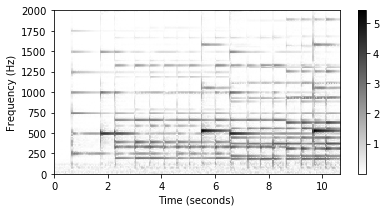

In [1]:
import os
import sys
import scipy
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
sys.path.append('..')
import libfmp.b
import libfmp.c1
import libfmp.c8
%matplotlib inline

Fs = 22050
fn_wav = os.path.join('..', 'data', 'C8', 'FMP_C8_Audio_Chopin_Op028-04_SMD_beginning.wav')
#fn_wav = os.path.join('..', 'data', 'C8', 'FMP_C8_Audio_Chopin_Op028-04_SMD.wav')
x, Fs = librosa.load(fn_wav, sr=Fs)
N_fft = 2048
H_fft = 1024
X = librosa.stft(x, n_fft=N_fft, hop_length=H_fft)
V = np.log(1 + np.abs(X))
#V = np.abs(X)
freq_max = 2000

libfmp.b.plot_matrix(V, Fs=Fs/H_fft, Fs_F=N_fft/Fs)
plt.ylim([0, freq_max]);

## NMF with Random Initialization

We now apply the [NMF algorithm](../C8/C8S3_NMFbasic.html) to the magnitude spectrogram of the our running example by iteratively updating the randomly initialized matrices $W^{(0)}$ and $H^{(0)}$. In the next figure, both the initialized and learned template and activation matrices are shown. In this example, the rank parameter was set to $R=8$, allowing one template for each of the eight different musical pitches occurring in the music example.

<!--<img src="../data/C8/FMP_C8_F22.png" width="500px" align="middle" alt="FMP_C8_F22">-->

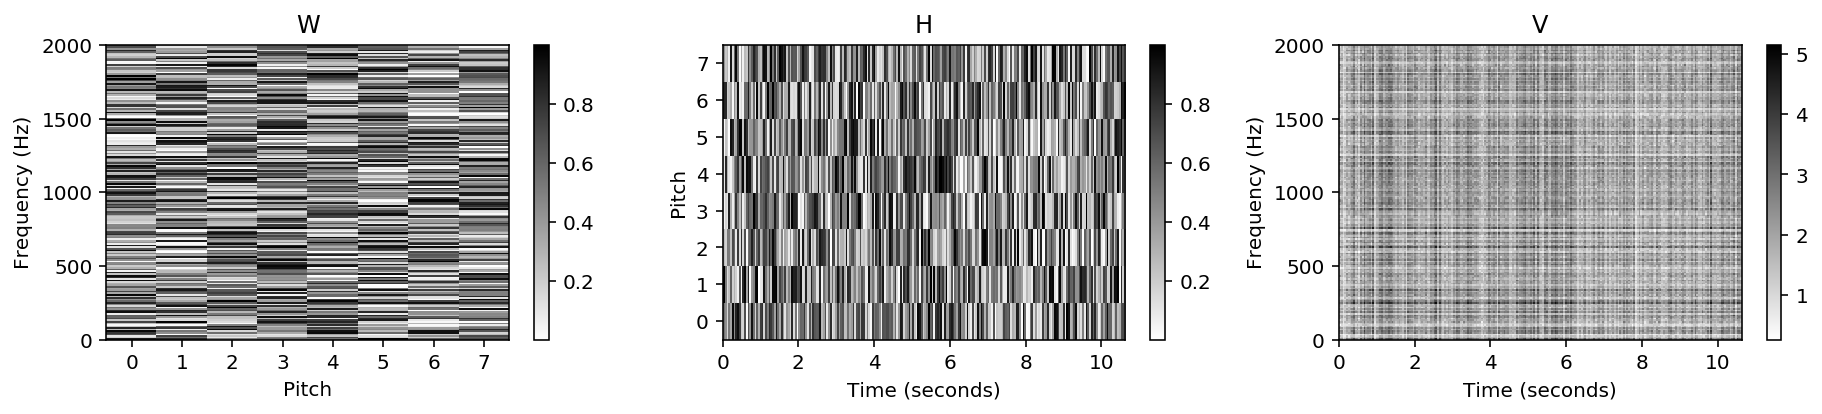

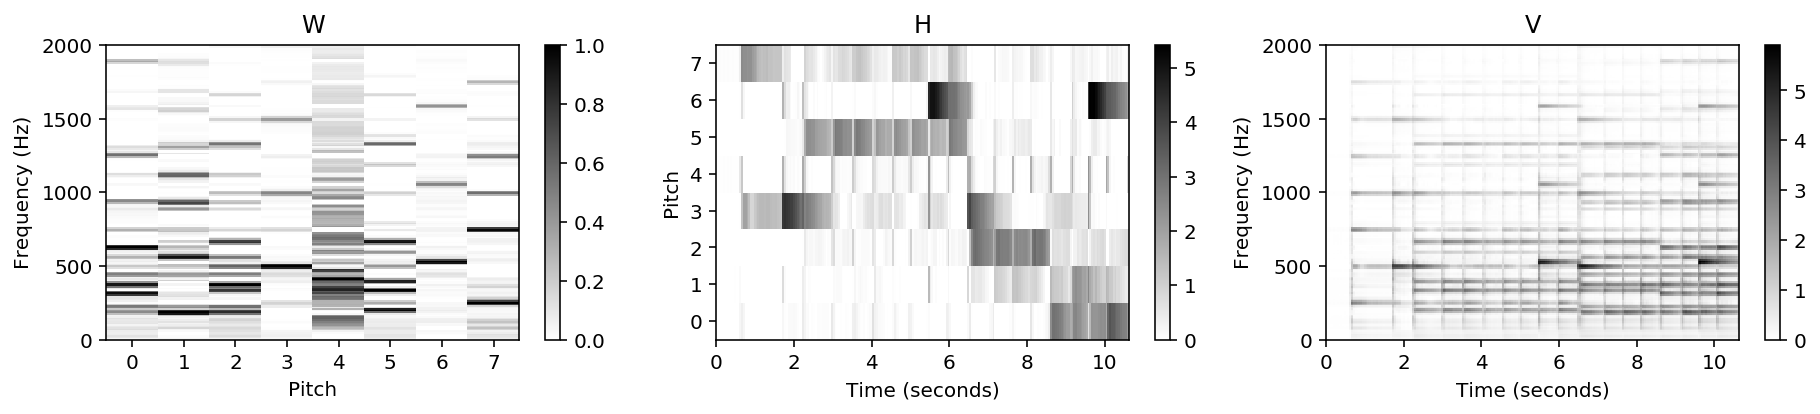

In [2]:
def plot_nmf_factors(W, H, V, Fs, N_fft, H_fft, freq_max, label_pitch=None,
                     title_W='W', title_H='H', title_V='V', figsize=(13, 3)):
    """Plots the factore of an NMF-based spectral decomposition

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        W: Template matrix
        H: Activation matrix
        V: Reconstructed input matrix
        Fs: Sampling frequency
        N_fft: FFT length
        H_fft: Hopsize
        freq_max: Maximum frequency to be plotted
        label_pitch: Labels for the different pitches (Default value = None)
        title_W: Title for imshow of matrix W (Default value = 'W')
        title_H: Title for imshow of matrix H (Default value = 'H')
        title_V: Title for imshow of matrix V (Default value = 'V')
        figsize: Size of the figure (Default value = (13, 3))
    """
    R = W.shape[1]
    N = H.shape[1]
    # cmap = libfmp.b.compressed_gray_cmap(alpha=5)
    cmap = 'gray_r'
    dur_sec = (N-1) * H_fft / Fs
    if label_pitch is None:
        label_pitch = np.arange(R)

    plt.figure(figsize=figsize)
    plt.subplot(131)
    plt.imshow(W, cmap=cmap, origin='lower', aspect='auto', extent=[0, R, 0, Fs/2], interpolation='nearest')
    plt.ylim([0, freq_max])
    plt.colorbar()
    plt.xticks(np.arange(R) + 0.5, label_pitch)
    plt.xlabel('Pitch')
    plt.ylabel('Frequency (Hz)')
    plt.title(title_W)

    plt.subplot(132)
    plt.imshow(H, cmap=cmap, origin='lower', aspect='auto', extent=[0, dur_sec, 0, R], interpolation='nearest')
    plt.colorbar()
    plt.yticks(np.arange(R) + 0.5, label_pitch)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Pitch')
    plt.title(title_H)

    plt.subplot(133)
    plt.imshow(V, cmap=cmap, origin='lower', aspect='auto', extent=[0, dur_sec, 0, Fs/2], interpolation='nearest')
    plt.ylim([0, freq_max])
    plt.colorbar()
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.title(title_V)

    plt.tight_layout()
    plt.show()

K = V.shape[0]
N = V.shape[1]
R = 8

W_init = np.random.rand(K,R)
H_init = np.random.rand(R,N)

W, H, V_approx, V_approx_err, H_W_error = libfmp.c8.nmf(V, R, W=W_init, H=H_init, L=200, norm=True)
#label_pitch=['54', '55', '57', '59', '63', '64', '71', '72']
plot_nmf_factors(W_init, H_init, W_init.dot(H_init), Fs, N_fft, H_fft, freq_max)
plot_nmf_factors(W, H, W.dot(H), Fs, N_fft, H_fft, freq_max)               

As demonstrated by this example, there are various issues with this approach. Looking at the learned template matrix $W$, it is not clear to which sound or pitch a given template corresponds. While only a few of the template vectors reveal a clear harmonic structure, most of the templates seem to correspond to mixtures of notes rather than individual notes. This is also indicated by the activation patterns in $H$, which can hardly be associated to a piano-roll representation of the score. In summary, even though the original matrix $V$ may be approximated well, simply applying the standard NMF approach based on a random initialization often produces a factorization that lacks clear musical semantics.

## Pitch-Informed Template Constraints

To overcome these issues, one important idea is to guide the NMF processing by imposing additional suitable constraints on $W$ and $H$. In this context, the multiplicative update rules again constitute a great advantage over additive rules. In the multiplicative case, zero-valued entries remain so during the entire learning process. Thanks to this property, one can enforce certain structures on $W$ and $H$ by setting suitable entries to zero in the initialization stage. Using this modified initialization, one can then apply the [standard NMF approach](../C8/C8S3_NMFbasic.html) in the subsequent learning process.

We now apply this strategy to enforce a harmonic structure in the templates of $W$. After assigning a musical pitch $p$ to each template vector, we can use the [center frequency](../C1/C1S3_FrequencyPitch.html)

$$
F_\mathrm{pitch}(p) = 2^{(p-69)/12} \cdot 440
$$ 

as an estimate of the fundamental frequency. From this, we can derive the approximate positions for the harmonics, which are roughly located at the integer multiples of the center frequency. As the exact frequencies are not known, a neighborhood around these positions can then be initialized with nonzero values in the templates, while setting the remaining entries to zero. This kind of initialization is used in the following example.

<!--<img src="../data/C8/FMP_C8_F23.png" width="500px" align="middle" alt="FMP_C8_F23">-->

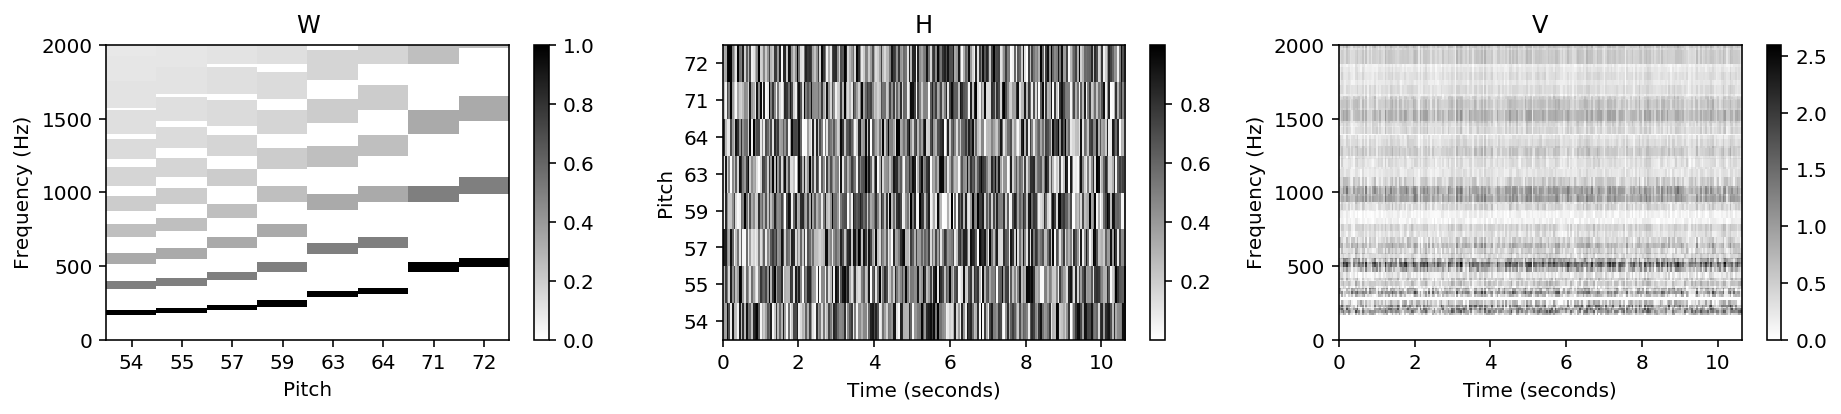

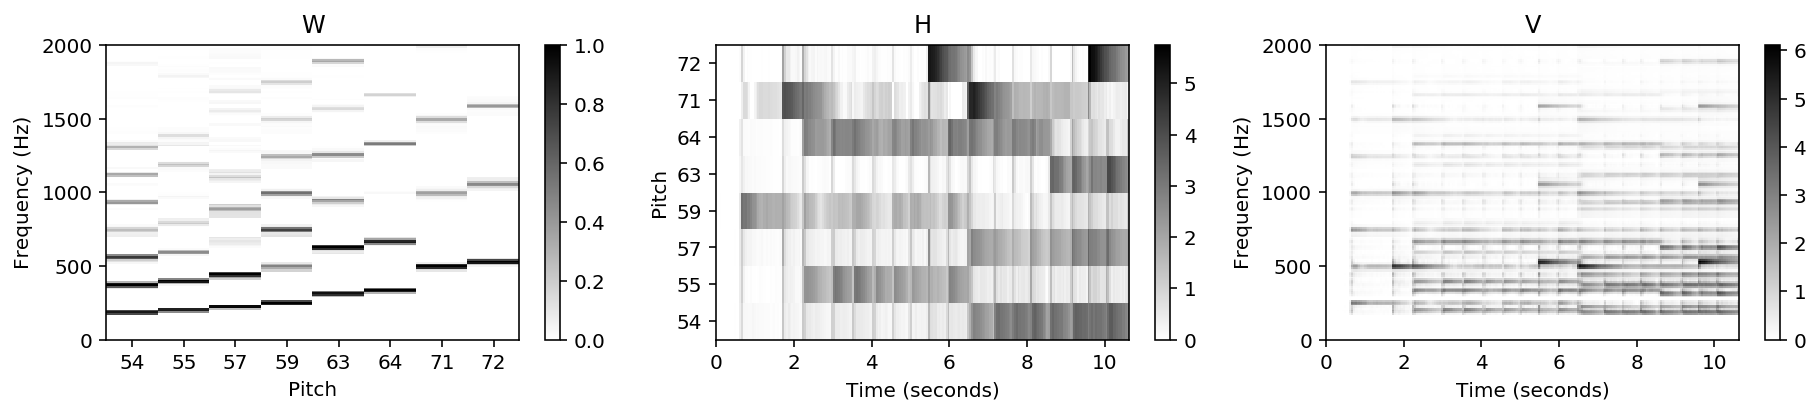

In [3]:
def pitch_from_annotation(annotation):
    """Extract set of occurring pitches from annotation

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        annotation (list): Annotation data

    Returns:
        pitch_set (np.ndarray): Set of occurring pitches
    """
    pitch_all = np.array([c[2] for c in annotation])
    pitch_set = np.unique(pitch_all)
    return pitch_set

def template_pitch(K, pitch, freq_res, tol_pitch=0.05):
    """Defines spectral template for a given pitch

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        K (int): Number of frequency points
        pitch (float): Fundamental pitch
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        template (np.ndarray): Nonnegative template vector of size K
    """
    max_freq = K * freq_res
    pitch_freq = 2**((pitch - 69) / 12) * 440
    max_order = int(np.ceil(max_freq / ((1 - tol_pitch) * pitch_freq)))
    template = np.zeros(K)
    for m in range(1, max_order + 1):
        min_idx = max(0, int((1 - tol_pitch) * m * pitch_freq / freq_res))
        max_idx = min(K-1, int((1 + tol_pitch) * m * pitch_freq / freq_res))
        template[min_idx:max_idx+1] = 1 / m
    return template
        
def init_nmf_template_pitch(K, pitch_set, freq_res, tol_pitch=0.05):
    """Initializes template matrix for a given set of pitches

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        K (int): Number of frequency points
        pitch_set (np.ndarray): Set of fundamental pitches
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        W (np.ndarray): Nonnegative matrix of size K x R with R = len(pitch_set)
    """
    R = len(pitch_set)
    W = np.zeros((K, R))
    for r in range(R):
        W[:, r] = template_pitch(K, pitch_set[r], freq_res, tol_pitch=tol_pitch)
    return W
    
fn_ann = os.path.join('..', 'data', 'C8', 'FMP_C8_Audio_Chopin_Op028-04_SMD_beginning.csv')
#fn_ann = os.path.join('..', 'data', 'C8', 'FMP_C8_Audio_Chopin_Op028-04_SMD.csv')
annotation = libfmp.c1.csv_to_list(fn_ann)
pitch_set = pitch_from_annotation(annotation)

K = V.shape[0]
N = V.shape[1]
R = pitch_set.shape[0]
freq_res = Fs / N_fft
W_init = init_nmf_template_pitch(K, pitch_set, freq_res, tol_pitch=0.05)
H_init = np.random.rand(R,N)

W, H, V_approx, V_approx_err, H_W_error = libfmp.c8.nmf(V, R, W=W_init, H=H_init, L=100, norm=True)
plot_nmf_factors(W_init, H_init, W_init.dot(H_init), Fs, N_fft, H_fft, freq_max, label_pitch=pitch_set)
plot_nmf_factors(W, H, W.dot(H), Fs, N_fft, H_fft, freq_max, label_pitch=pitch_set)    

The learning process based on multiplicative update rules not only retains the harmonic structure but further refines it. At the same time, the activation matrix reflects the presence and the intensity of the played notes quite well. Note that the vertical structures in the activation matrix are the result of short-time energy bursts that are related to the note onsets' transients. These structures are not well reflected by the harmonically informed templates and are "synthesized" as superposition of all templates. 

## Score-Informed Activation Constraints

If additional prior knowledge is available, it can be exploited to further stabilize the factorization process. In this context, a musical score is particularly valuable. On a coarse level, we can extract **global information** from the score, such as which instruments are playing or which and how many pitches occur over the course of a piece of music.
In our example, this information can be used to set the number of templates automatically to $R=8$. One can also refine the initialization of the templates using instrument-dependent harmonic models, which may be derived from example recordings of isolated notes. On a finer level, one may also exploit **local information** about when notes are actually played. Assuming that the note events specified by the score are aligned to the time positions where they occur in the audio recording, one can impose time constraints on where certain templates may become active. To this end, one initializes suitable regions in $H^{(0)}$ by setting the corresponding activation entries to one. The remaining entries are set to zero. Such a score-informed initialization is used in the following figure. For example, the activation entries corresponding to pitch $p=55$ are constrained to the time interval ranging from roughly $t=2$ to $t=7$ (given in seconds). 

<!--<img src="../data/C8/FMP_C8_F24.png" width="500px" align="middle" alt="FMP_C8_F24">-->

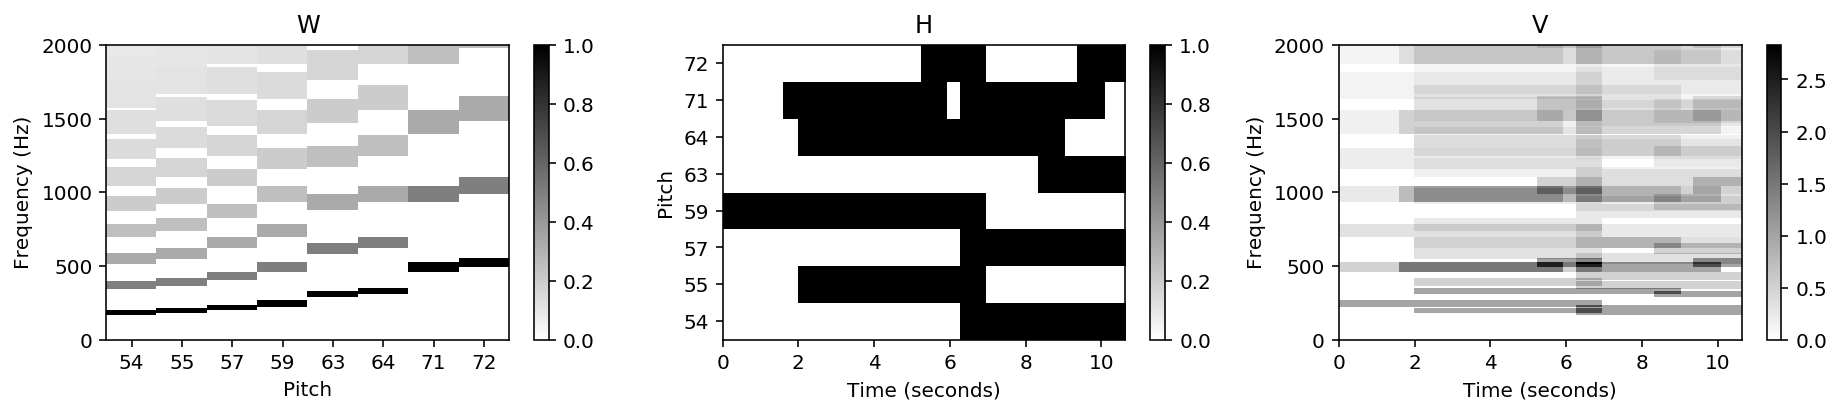

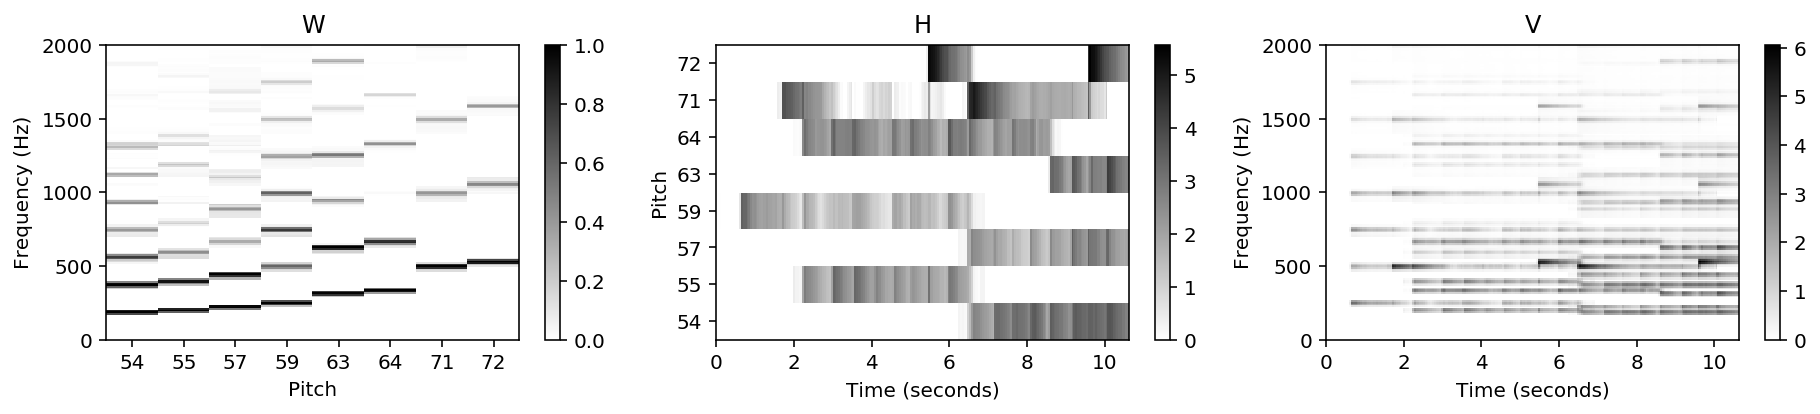

In [4]:
def init_nmf_activation_score(N, annotation, frame_res, tol_note=[0.2, 0.5], pitch_set=None):
    """Initializes activation matrix for given score annotations

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        N (int): Number of frames
        annotation (list): Annotation data
        frame_res (time): Time resolution
        tol_note (list or np.ndarray): Tolerance (seconds) for beginning and end of a note (Default value = [0.2, 0.5])
        pitch_set (np.ndarray): Set of occurring pitches (Default value = None)

    Returns:
        H (np.ndarray): Nonnegative matrix of size R x N
        pitch_set (np.ndarray): Set of occurring pitches
    """
    note_start = np.array([c[0] for c in annotation])
    note_dur = np.array([c[1] for c in annotation])
    pitch_all = np.array([c[2] for c in annotation])
    if pitch_set is None:
        pitch_set = np.unique(pitch_all)
    R = len(pitch_set)
    H = np.zeros((R, N))
    for i in range(len(note_start)):
        start_idx = max(0, int((note_start[i] - tol_note[0]) / frame_res))
        end_idx = min(N, int((note_start[i] + note_dur[i] + tol_note[1]) / frame_res))
        pitch_idx = np.argwhere(pitch_set == pitch_all[i])
        H[pitch_idx, start_idx:end_idx] = 1
    return H, pitch_set

frame_res = H_fft/Fs
H_init, pitch_set = init_nmf_activation_score(N, annotation, frame_res, tol_note=[0.2, 0.5])

W, H, V_approx, V_approx_err, H_W_error = libfmp.c8.nmf(V, R, W=W_init, H=H_init, L=100, norm=True)
plot_nmf_factors(W_init, H_init, W_init.dot(H_init), Fs, N_fft, H_fft, freq_max, label_pitch=pitch_set)
plot_nmf_factors(W, H, W.dot(H), Fs, N_fft, H_fft, freq_max, label_pitch=pitch_set)

To account for possible alignment inaccuracies, the temporal boundaries for the constraint regions can be chosen in a rather generous fashion. As a result, the activation matrix $H$ can be interpreted as a coarse piano-roll representation of the synchronized score information. In a sense, the synchronization step can be seen as yielding a first approximate factorization, which is then refined by the NMF-based learning procedure. As expected, combining the activation constraints with those for the template vectors further stabilizes the factorization in the sense that the result better reflects the desired semantics.

## Onset Model

So far, the NMF-based decomposition only represents harmonic properties of the signal. To also account for percussive properties such as onsets, we now show how one may extend the NMF model by introducing additional templates. A first idea is to use one additional template that jointly explains the onsets for all pitches. However, since the spectral patterns for note onsets may not be completely independent from the respective pitch (as is the case with the piano), we use in the following one additional **onset template** for **each pitch**. In general, it is hard to predict the spectral shape of an onset template.  Therefore, in contrast to the harmonic templates, we do not enforce any spectral constraints, but initialize the onset templates uniformly and let the learning process derive their respective shapes. While it is hard to find meaningful spectral constraints for the onset templates, the **short-time nature of note onsets** makes it possible to introduce relatively **strict temporal constraints** on the activation side. Using the synchronized score information, one has a rough estimate for the onset positions. Within a small neighborhood around each of these positions (accounting for possible synchronization inaccuracies), we initialize the corresponding activation entries with one, while setting all remaining entries to zero. This strongly constrains the time points where onset templates are allowed to become active. In the following example, we use such an extended NMF model with initializations on the template and activation side.

<!--<img src="../data/C8/FMP_C8_F25.png" width="500px" align="middle" alt="FMP_C8_F25">-->

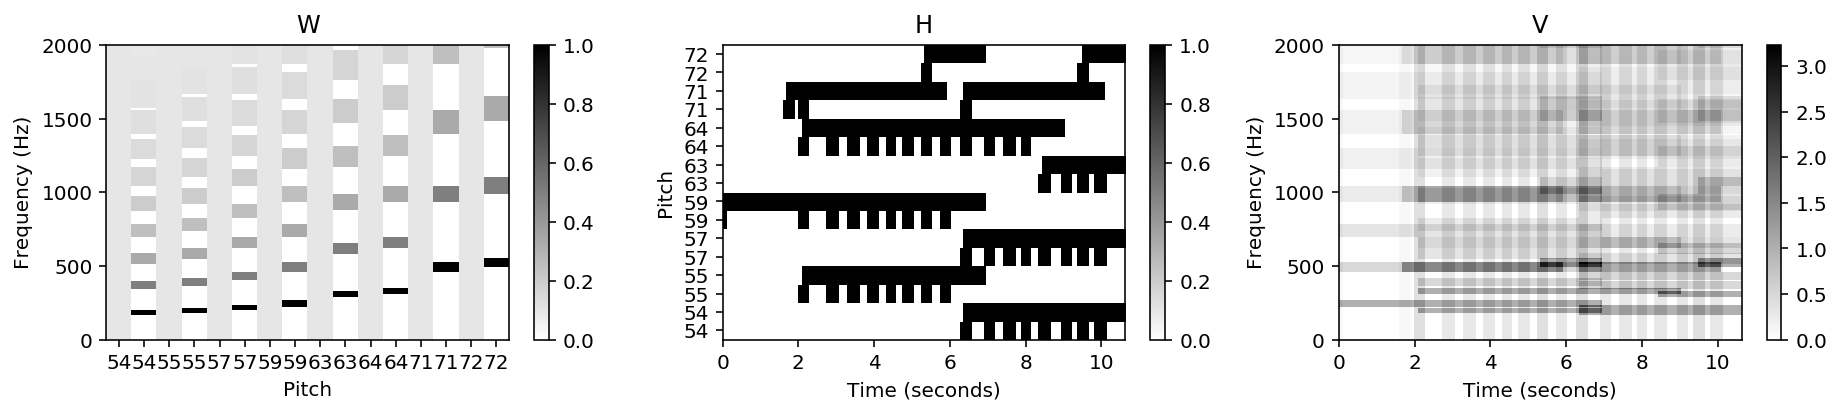

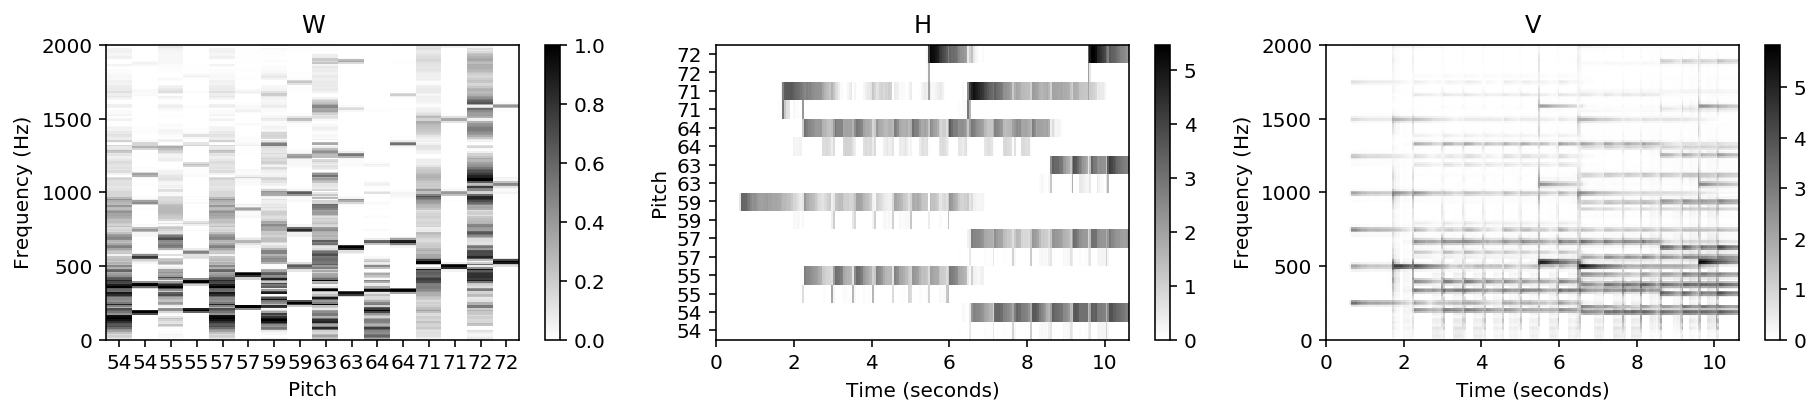

In [5]:
def init_nmf_template_pitch_onset(K, pitch_set, freq_res, tol_pitch=0.05):
    """Initializes template matrix with onsets for a given set of pitches

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        K (int): Number of frequency points
        pitch_set (np.ndarray): Set of fundamental pitches
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        W (np.ndarray): Nonnegative matrix of size K x (2R) with R = len(pitch_set)
    """
    R = len(pitch_set)
    W = np.zeros((K, 2*R))
    for r in range(R):
        W[:, 2*r] = 0.1
        W[:, 2*r+1] = template_pitch(K, pitch_set[r], freq_res, tol_pitch=tol_pitch)
    return W

def init_nmf_activation_score_onset(N, annotation, frame_res, tol_note=[0.2, 0.5], tol_onset=[0.3, 0.1],
                                    pitch_set=None):
    """Initializes activation matrix with onsets for given score annotations

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        N (int): Number of frames
        annotation (list): Annotation data
        frame_res (float): Time resolution
        tol_note (list or np.ndarray): Tolerance (seconds) for beginning and end of a note (Default value = [0.2, 0.5])
        tol_onset (list or np.ndarray): Tolerance (seconds) for beginning and end of an onset
            (Default value = [0.3, 0.1])
        pitch_set (np.ndarray): Set of occurring pitches (Default value = None)

    Returns:
        H (np.ndarray): Nonnegative matrix of size (2R) x N
        pitch_set (np.ndarray): Set of occurring pitches
        label_pitch (np.ndarray): Pitch labels for the templates
    """
    note_start = np.array([c[0] for c in annotation])
    note_dur = np.array([c[1] for c in annotation])
    pitch_all = np.array([c[2] for c in annotation])
    if pitch_set is None:
        pitch_set = np.unique(pitch_all)
    R = len(pitch_set)
    H = np.zeros((2*R, N))
    for i in range(len(note_start)):
        start_idx = max(0, int((note_start[i] - tol_note[0]) / frame_res))
        end_idx = min(N, int((note_start[i] + note_dur[i] + tol_note[1]) / frame_res))
        start_onset_idx = max(0, int((note_start[i] - tol_onset[0]) / frame_res))
        end_onset_idx = min(N, int((note_start[i] + tol_onset[1]) / frame_res))
        pitch_idx = np.argwhere(pitch_set == pitch_all[i])
        H[2*pitch_idx, start_onset_idx:end_onset_idx] = 1
        H[2*pitch_idx+1, start_idx:end_idx] = 1
    label_pitch = np.zeros(2*len(pitch_set),  dtype=int)
    for k in range(len(pitch_set)):
        label_pitch[2*k] = pitch_set[k]
        label_pitch[2*k+1] = pitch_set[k]
    return H, pitch_set, label_pitch


H_init, pitch_set, label_pitch = init_nmf_activation_score_onset(N, annotation, frame_res, 
                                                    tol_note=[0.1, 0.5], tol_onset=[0.2, 0.1])
W_init = init_nmf_template_pitch_onset(K, pitch_set, freq_res, tol_pitch=0.05)

W, H, V_approx, V_approx_err, H_W_error = libfmp.c8.nmf(V, 2*R, W=W_init, H=H_init, L=100, norm=True)
plot_nmf_factors(W_init, H_init, W_init.dot(H_init), Fs, N_fft, H_fft, freq_max, label_pitch=label_pitch )
plot_nmf_factors(W, H, W.dot(H), Fs, N_fft, H_fft, freq_max, label_pitch=label_pitch )

As illustrated by the figure, the learned **harmonic templates** have a much cleaner harmonic structure compared with the ones in previous factorizations. The reason is that most of the transients' broadband energy is now captured by the **onset templates**. Furthermore, one can observe an impulse-like activation pattern at the beginning of note events for most of the onset templates. This indicates that these templates indeed represent onsets. Having a closer look at the onset templates, one can observe a spread of energy across many different spectral coefficients. Often, the spread is concentrated in regions around the fundamental frequency and the first harmonic.

## Further Notes

In summary, we have seen that a combination of template and activation constraints may significantly stabilize and guide an NMF-based factorization process to yield a musically meaningful decomposition. In this process, constraints on the activation side can compensate for using relatively loose or even no constraints on the template side and vice versa. We close this notebook with some final remarks.

* Note that the constraints introduced are hard in the sense that zero entries in $W^{(0)}$ and $H^{(0)}$ **remain zero** throughout the learning process. Therefore, one should use rather generous constraint regions to account for potential synchronization inaccuracies and to retain a certain degree of flexibility. 

* We want to emphasize that using hard constraints by setting certain coefficients to zero allows for using exactly the same **multiplicative update rules** as in standard NMF. Thus the constrained procedure inherits the **ease of implementation** and **computational efficiency** of the original approach. This is one of the most advantageous aspects of using NMF.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and Tim Zunner.</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>